In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

## Obtaining the predictors
In this case we will bring all the variables to start working with everything

In [2]:
from raster_api.tools import RasterData
from raster_api.models import raster_models_dic as models


In [3]:
from sketches.models import Country
from mesh.models import MexMesh

Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)

### Obtaining everything

In [4]:
datadict = { key : RasterData(models[key],border=Mexico.geom) for key,value in models.iteritems()}

In [5]:
#from django.db import connections
#connections.close_all()

In [6]:
## Without resamling (whole data)
pixel_size = 0.25
%time datacube_field = map(lambda raster : raster.rescale(pixel_size),datadict.itervalues())
datacube = datacube_field

CPU times: user 312 ms, sys: 12 ms, total: 324 ms
Wall time: 4min 34s


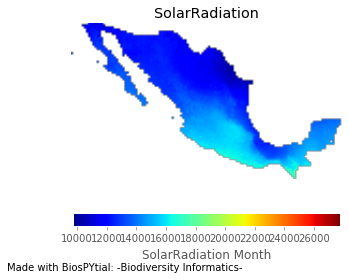

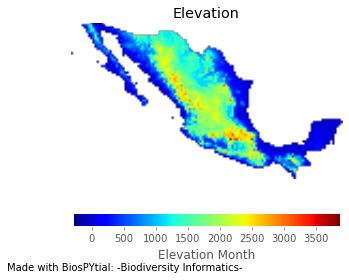

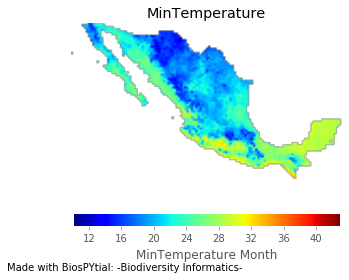

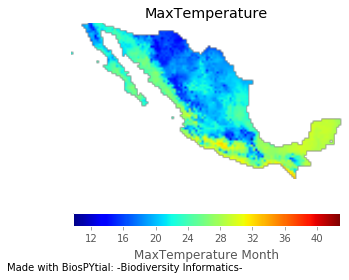

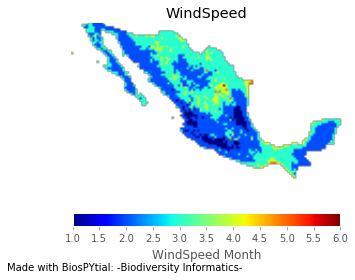

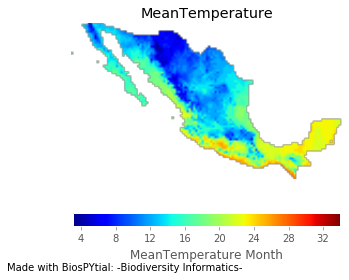

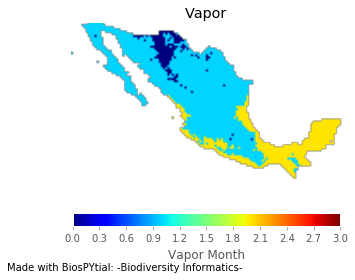

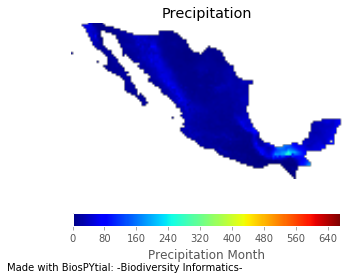

[None, None, None, None, None, None, None, None]

In [7]:
map(lambda (k,d) : d.display_field(title=k,origin='Lower'),datadict.iteritems())

## For the moment we don't want to do temporal analysis so we need to aggregate the array by the mean.

Using the new 'resample' method

In [9]:
# Take mean of everything
cubes = map(lambda (k,v): np.mean(v.toNumpyArray(),axis=0), datadict.iteritems())

The coordinates are the same so, we can extract the them with getCoordinates and then append everything as a flat array

In [10]:
coords = map(lambda (k,v) : v.getCoordinates(),datadict.iteritems())

In [11]:
coords = pd.concat(coords,axis=1)

In [12]:
coords1 = coords[[0,1]]

In [13]:
## Oke I need a way to extract the dataframe, maybe aggregate it by mean 
dataframe_cube = map(lambda cube: pd.DataFrame(cube.flatten()),cubes)

In [14]:
datacube = pd.concat(dataframe_cube,axis=1)

In [15]:
datacube = pd.concat([datacube,coords1],axis=1)

In [16]:
datacube.columns = datadict.keys() + list(coords1.columns)

In [17]:
datacube_clean = datacube.dropna()

In [18]:
## Convert to geopandas
from external_plugins.spystats.spystats import tools as tl
datacube_clean = tl.toGeoDataFrame(datacube_clean,xcoord_name='Longitude',ycoord_name='Latitude')

/apps/external_plugins/spystats/spystats/tools.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['geometry'] = data.apply(lambda z : Point(z[xcoord_name], z[ycoord_name]), axis=1)


In [ ]:
## Save the dataframe. I haven't done that.